In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class OptimizedCryptoBacktester:
    def __init__(self, data_path, start_date='2023-01-01', end_date='2025-12-31'):
        """
        최적화된 라벨용 암호화폐 백테스터
        
        Parameters:
        -----------
        data_path : str
            최적화된 CSV 파일들이 저장된 경로
        start_date : str
            백테스팅 시작 날짜
        end_date : str
            백테스팅 종료 날짜
        """
        self.data_path = data_path
        self.start_date = start_date
        self.end_date = end_date
        self.cryptos_data = {}
        self.results = {}
        
    def load_data(self):
        """최적화된 CSV 파일들 로딩"""
        print(f"📁 데이터 로딩: {self.data_path}")
        
        # 최적화된 파일들 우선 검색
        patterns = [
            "*_optimized.csv",    # 최적화된 파일들 우선
            "*_labeled_dataset.csv",
            "*_enhanced.csv", 
            "*.csv"
        ]
        
        csv_files = []
        used_pattern = None
        
        for pattern in patterns:
            files = glob.glob(os.path.join(self.data_path, pattern))
            if files:
                csv_files = files
                used_pattern = pattern
                print(f"✅ 파일 패턴 발견: {pattern} ({len(files)}개)")
                break
        
        if not csv_files:
            raise FileNotFoundError(f"❌ CSV 파일을 찾을 수 없습니다: {self.data_path}")
        
        print(f"🚀 CSV 파일 로딩 중... ({len(csv_files)}개)")
        
        loaded_count = 0
        for file_path in tqdm(csv_files):
            try:
                # 심볼명 추출
                filename = os.path.basename(file_path)
                symbol = filename.replace('.csv', '')
                
                # 다양한 접미사 제거
                for suffix in ['_optimized', '_labeled_dataset', '_enhanced', '_processed']:
                    symbol = symbol.replace(suffix, '')
                
                # CSV 읽기
                df = pd.read_csv(file_path)
                
                if df.empty:
                    continue
                
                # 날짜 컬럼 처리
                if 'Date' in df.columns:
                    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
                    if df['Date'].dt.tz is not None:
                        df['Date'] = df['Date'].dt.tz_localize(None)
                    df = df.set_index('Date')
                elif 'Unnamed: 0' in df.columns:
                    df.index = pd.to_datetime(df['Unnamed: 0'], errors='coerce')
                    df = df.drop('Unnamed: 0', axis=1)
                
                # 사용할 라벨 컬럼 결정 (우선순위 설정)
                label_priority = [
                    ('Optimized_Label', 'Optimized_Label_Name'),
                    ('Future_Label', 'Future_Label_Name'),
                    ('Label', 'Label_Name')
                ]
                
                label_col = None
                label_name_col = None
                
                for label_candidate, name_candidate in label_priority:
                    if label_candidate in df.columns:
                        label_col = label_candidate
                        label_name_col = name_candidate
                        break
                
                # 라벨 컬럼이 없으면 건너뛰기
                if label_col is None or 'Close' not in df.columns:
                    print(f"⚠️ {symbol}: 필수 컬럼 누락")
                    continue
                
                # Label_Name이 없으면 생성
                if label_name_col not in df.columns:
                    label_map = {0: 'Strong_Sell', 1: 'Hold', 2: 'Strong_Buy'}
                    df[label_name_col] = df[label_col].map(label_map)
                
                # 표준 컬럼명으로 복사 (백테스터 호환성)
                df['Label'] = df[label_col]
                df['Label_Name'] = df[label_name_col]
                
                # 날짜 필터링
                start_dt = pd.to_datetime(self.start_date)
                end_dt = pd.to_datetime(self.end_date)
                
                # 인덱스 timezone 처리
                if hasattr(df.index, 'tz') and df.index.tz is not None:
                    df.index = df.index.tz_localize(None)
                
                df = df[(df.index >= start_dt) & (df.index <= end_dt)]
                
                # 최소 데이터 확인
                if len(df) >= 30:
                    self.cryptos_data[symbol] = df
                    loaded_count += 1
                    
                    # 사용된 라벨 정보 출력
                    label_dist = df['Label'].value_counts().sort_index()
                    print(f"✅ {symbol}: {len(df)}일, 라벨={label_col}, 분포={dict(label_dist)}")
                
            except Exception as e:
                print(f"❌ {filename}: {e}")
                continue
        
        print(f"✅ 로딩 완료: {loaded_count}개 암호화폐")
        return self.cryptos_data
    
    def simulate_trading(self, symbol, initial_capital=10000, transaction_cost=0.002):
        """최적화된 라벨 기반 암호화폐 매매 시뮬레이션"""
        
        df = self.cryptos_data[symbol].copy()
        
        # 시뮬레이션 변수
        cash = initial_capital
        coins = 0
        portfolio_values = []
        trades = []
        position = 'CASH'  # CASH, LONG
        
        for date, row in df.iterrows():
            current_price = row['Close']
            label = row['Label']
            label_name = row['Label_Name']
            
            # 포트폴리오 가치 계산
            portfolio_value = cash + (coins * current_price)
            portfolio_values.append(portfolio_value)
            
            # 최적화된 라벨에 따른 매매 신호 처리
            if label == 2 and position == 'CASH':  # Strong_Buy (라벨=2) 신호
                coins_to_buy = cash / (current_price * (1 + transaction_cost))
                if coins_to_buy > 0:
                    coins += coins_to_buy
                    cash -= coins_to_buy * current_price * (1 + transaction_cost)
                    position = 'LONG'
                    
                    trades.append({
                        'date': date,
                        'action': 'BUY',
                        'price': current_price,
                        'coins': coins_to_buy,
                        'value': coins_to_buy * current_price,
                        'label': label_name
                    })
            
            elif label == 0 and position == 'LONG':  # Strong_Sell (라벨=0) 신호
                if coins > 0:
                    sale_value = coins * current_price * (1 - transaction_cost)
                    cash += sale_value
                    
                    trades.append({
                        'date': date,
                        'action': 'SELL',
                        'price': current_price,
                        'coins': coins,
                        'value': sale_value,
                        'label': label_name
                    })
                    
                    coins = 0
                    position = 'CASH'
            
            # Hold (라벨=1)일 때는 기존 포지션 유지
        
        # 최종 정산 (보유 코인 강제 매도)
        if coins > 0:
            final_price = df.iloc[-1]['Close']
            final_value = coins * final_price * (1 - transaction_cost)
            cash += final_value
            
            trades.append({
                'date': df.index[-1],
                'action': 'FINAL_SELL',
                'price': final_price,
                'coins': coins,
                'value': final_value,
                'label': 'FINAL'
            })
        
        # 결과 계산
        df['Portfolio_Value'] = portfolio_values
        final_value = cash
        total_return = (final_value - initial_capital) / initial_capital
        
        # Buy & Hold 비교
        buy_hold_return = (df.iloc[-1]['Close'] - df.iloc[0]['Close']) / df.iloc[0]['Close']
        
        # 샤프 비율 (암호화폐용 √365)
        daily_returns = df['Portfolio_Value'].pct_change().dropna()
        sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(365) if daily_returns.std() > 0 else 0
        
        # 최대 손실폭
        peak = df['Portfolio_Value'].expanding().max()
        drawdown = (df['Portfolio_Value'] - peak) / peak
        max_drawdown = drawdown.min()
        
        # 승률 계산 (매매 쌍별)
        trade_returns = []
        buy_trades = [t for t in trades if t['action'] == 'BUY']
        sell_trades = [t for t in trades if t['action'] in ['SELL', 'FINAL_SELL']]
        
        for buy_trade, sell_trade in zip(buy_trades, sell_trades):
            if buy_trade and sell_trade:
                trade_return = (sell_trade['price'] - buy_trade['price']) / buy_trade['price']
                trade_returns.append(trade_return)
        
        win_rate = sum(1 for r in trade_returns if r > 0) / len(trade_returns) if trade_returns else 0
        avg_trade_return = np.mean(trade_returns) if trade_returns else 0
        
        return {
            'symbol': symbol,
            'initial_capital': initial_capital,
            'final_value': final_value,
            'total_return': total_return,
            'buy_hold_return': buy_hold_return,
            'excess_return': total_return - buy_hold_return,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'num_trades': len(trades),
            'win_rate': win_rate,
            'avg_trade_return': avg_trade_return,
            'trades': trades,
            'portfolio_values': df['Portfolio_Value'].values,
            'dates': df.index.values,
            'data_points': len(df)
        }
    
    def plot_individual_crypto(self, symbol, figsize=(16, 8)):
        """개별 암호화폐 백테스팅 결과 시각화 (최적화 버전)"""
        
        if symbol not in self.results:
            print(f"❌ {symbol} 결과가 없습니다.")
            return
        
        result = self.results[symbol]
        df = self.cryptos_data[symbol]
        
        fig, axes = plt.subplots(3, 1, figsize=figsize)
        
        # 1. 가격 차트 + 매매 신호
        ax1 = axes[0]
        ax1.plot(df.index, df['Close'], label='Close Price', alpha=0.8, color='black', linewidth=1.5)
        
        # 매매 포인트 표시
        trades = result['trades']
        buy_trades = [t for t in trades if t['action'] == 'BUY']
        sell_trades = [t for t in trades if t['action'] in ['SELL', 'FINAL_SELL']]
        
        if buy_trades:
            buy_dates = [t['date'] for t in buy_trades]
            buy_prices = [t['price'] for t in buy_trades]
            ax1.scatter(buy_dates, buy_prices, color='green', marker='^', 
                       s=120, label=f'Buy Signals ({len(buy_trades)})', zorder=5, alpha=0.8)
        
        if sell_trades:
            sell_dates = [t['date'] for t in sell_trades]
            sell_prices = [t['price'] for t in sell_trades]
            ax1.scatter(sell_dates, sell_prices, color='red', marker='v', 
                       s=120, label=f'Sell Signals ({len(sell_trades)})', zorder=5, alpha=0.8)
        
        ax1.set_title(f'{symbol} - Price & Optimized Trading Signals', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Price ($)', fontsize=12)
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)
        
        # 2. 포트폴리오 vs Buy&Hold 비교
        ax2 = axes[1]
        ax2.plot(df.index, result['portfolio_values'], label='Optimized Strategy', 
                color='blue', linewidth=2)
        
        buy_hold_values = (df['Close'] / df.iloc[0]['Close']) * result['initial_capital']
        ax2.plot(df.index, buy_hold_values, label='Buy & Hold', 
                color='orange', alpha=0.8, linewidth=2)
        
        ax2.set_title('Portfolio Value Comparison (Optimized)', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Portfolio Value ($)', fontsize=12)
        ax2.legend(fontsize=10)
        ax2.grid(True, alpha=0.3)
        
        # 3. 라벨 분포 비교 (원본 vs 최적화)
        ax3 = axes[2]
        
        # 원본 라벨과 최적화된 라벨 비교 (있는 경우)
        if 'Optimized_Label' in df.columns and 'Label' in df.columns:
            # 최적화된 라벨 분포
            opt_label_counts = df['Optimized_Label'].value_counts().sort_index()
            
            # 원본 라벨 분포 (Label이 아닌 다른 컬럼이 있는지 확인)
            original_label_col = None
            for col in ['Future_Label', 'Original_Label']:
                if col in df.columns:
                    original_label_col = col
                    break
            
            if original_label_col:
                orig_label_counts = df[original_label_col].value_counts().sort_index()
            else:
                orig_label_counts = df['Label'].value_counts().sort_index()
            
            # 라벨 분포 막대 그래프
            x = np.arange(3)
            width = 0.35
            
            opt_counts = [opt_label_counts.get(i, 0) for i in [0, 1, 2]]
            orig_counts = [orig_label_counts.get(i, 0) for i in [0, 1, 2]]
            
            ax3.bar(x - width/2, orig_counts, width, label='Original', alpha=0.7, color='lightblue')
            ax3.bar(x + width/2, opt_counts, width, label='Optimized', alpha=0.7, color='darkblue')
            
            ax3.set_title('Label Distribution Comparison', fontsize=14, fontweight='bold')
            ax3.set_xlabel('Signal Types')
            ax3.set_ylabel('Count')
            ax3.set_xticks(x)
            ax3.set_xticklabels(['Strong_Sell', 'Hold', 'Strong_Buy'])
            ax3.legend()
            
        else:
            # 단일 라벨 분포만 표시
            label_counts = df['Label'].value_counts().sort_index()
            colors = ['red', 'gray', 'green']
            
            for i in [0, 1, 2]:
                if i not in label_counts:
                    label_counts[i] = 0
            
            bars = ax3.bar(range(3), [label_counts[i] for i in [0, 1, 2]], 
                          color=colors, alpha=0.7)
            ax3.set_title('Optimized Label Distribution', fontsize=14, fontweight='bold')
            ax3.set_xticks(range(3))
            ax3.set_xticklabels(['Strong_Sell', 'Hold', 'Strong_Buy'])
            ax3.set_ylabel('Count')
        
        # # 4. 일일 수익률 히스토그램
        # ax4 = axes[3]
        # daily_returns = pd.Series(result['portfolio_values']).pct_change().dropna()
        # ax4.hist(daily_returns, bins=50, alpha=0.7, color='blue', edgecolor='black')
        # ax4.axvline(daily_returns.mean(), color='red', linestyle='--', 
        #            label=f'Mean: {daily_returns.mean():.4f}')
        # ax4.set_title('Daily Returns Distribution', fontsize=14, fontweight='bold')
        # ax4.set_xlabel('Daily Return')
        # ax4.set_ylabel('Frequency')
        # ax4.legend(fontsize=10)
        # ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # 결과 요약 출력
        print(f"\n{'='*70}")
        print(f"🚀 {symbol} 최적화된 백테스팅 결과")
        print(f"{'='*70}")
        print(f"📈 전략 수익률: {result['total_return']:.2%}")
        print(f"📊 Buy & Hold: {result['buy_hold_return']:.2%}")
        print(f"⚡ 초과수익률: {result['excess_return']:.2%}")
        print(f"📐 샤프 비율: {result['sharpe_ratio']:.3f}")
        print(f"📉 최대손실폭: {result['max_drawdown']:.2%}")
        print(f"🔄 거래 횟수: {result['num_trades']}회")
        print(f"🎯 승률: {result['win_rate']:.2%}")
        print(f"💰 평균 거래수익률: {result['avg_trade_return']:.2%}")
        print(f"💵 최종 자산: ${result['final_value']:,.0f}")
        print(f"📅 기간: {df.index[0].date()} ~ {df.index[-1].date()}")
        print(f"📊 데이터 포인트: {result['data_points']}일")
        
        plt.show()
    
    def get_summary_stats(self):
        """전체 백테스팅 결과 요약"""
        if not self.results:
            print("❌ 백테스팅 결과가 없습니다.")
            return None
        
        summary_data = []
        for symbol, result in self.results.items():
            summary_data.append({
                'Symbol': symbol,
                'Total_Return': result['total_return'],
                'Buy_Hold_Return': result['buy_hold_return'],
                'Excess_Return': result['excess_return'],
                'Sharpe_Ratio': result['sharpe_ratio'],
                'Max_Drawdown': result['max_drawdown'],
                'Win_Rate': result['win_rate'],
                'Num_Trades': result['num_trades'],
                'Data_Points': result['data_points']
            })
        
        summary_df = pd.DataFrame(summary_data).sort_values('Total_Return', ascending=False)
        
        print(f"\n{'='*100}")
        print("🎯 최적화된 전체 백테스팅 결과 요약")
        print(f"{'='*100}")
        print(summary_df.to_string(index=False, float_format='%.4f'))
        
        # 평균 통계
        print(f"\n📊 평균 통계:")
        print(f"   평균 수익률: {summary_df['Total_Return'].mean():.2%}")
        print(f"   평균 초과수익률: {summary_df['Excess_Return'].mean():.2%}")
        print(f"   평균 샤프비율: {summary_df['Sharpe_Ratio'].mean():.3f}")
        print(f"   평균 승률: {summary_df['Win_Rate'].mean():.2%}")
        
        return summary_df

def run_individual_backtest(data_path, start_date='2023-01-01', end_date='2025-12-31', 
                           symbols=None, max_stocks=10, initial_capital=10000):
    """
    최적화된 라벨 기반 암호화폐 백테스팅 실행
    """
    
    print(f"🚀 최적화된 암호화폐 백테스팅 시작!")
    print(f"📁 데이터 경로: {data_path}")
    print(f"📅 백테스팅 기간: {start_date} ~ {end_date}")
    print(f"💰 초기 자본: ${initial_capital:,}")
    print(f"🏷️ 라벨 전략: 최적화된 3단계 라벨")
    
    # 백테스터 생성
    backtester = OptimizedCryptoBacktester(data_path, start_date, end_date)
    
    # 데이터 로딩
    try:
        backtester.load_data()
    except Exception as e:
        print(f"❌ 데이터 로딩 실패: {e}")
        return None, None
    
    if not backtester.cryptos_data:
        print("❌ 로딩된 데이터가 없습니다.")
        return None, None
    
    # 테스트할 종목 선택
    if symbols:
        cryptos_to_test = [s for s in symbols if s in backtester.cryptos_data]
    else:
        cryptos_to_test = list(backtester.cryptos_data.keys())[:max_stocks]
    
    print(f"\n🎯 테스트 대상: {len(cryptos_to_test)}개 암호화폐")
    print(f"📝 종목 목록: {', '.join(cryptos_to_test)}")
    print("-" * 80)
    
    # 각 종목별 백테스팅 및 시각화
    successful_backtests = 0
    for symbol in tqdm(cryptos_to_test, desc="최적화된 백테스팅"):
        try:
            result = backtester.simulate_trading(symbol, initial_capital)
            if result:
                backtester.results[symbol] = result
                successful_backtests += 1
                
                # 개별 차트 출력
                backtester.plot_individual_crypto(symbol)
            else:
                print(f"⚠️ {symbol}: 백테스팅 실패")
                
        except Exception as e:
            print(f"❌ {symbol}: 백테스팅 중 오류 - {e}")
            continue
    
    print(f"\n✅ 백테스팅 완료: {successful_backtests}/{len(cryptos_to_test)}개 성공")
    
    # 전체 결과 요약
    if backtester.results:
        summary_df = backtester.get_summary_stats()
        return backtester, summary_df
    else:
        print("❌ 성공한 백테스팅이 없습니다.")
        return None, None



🚀 최적화된 암호화폐 백테스팅 시작!
📁 데이터 경로: /workspace/AI모델/projects/coin/data/v01/optimized
📅 백테스팅 기간: 2024-02-17 ~ 2025-09-27
💰 초기 자본: $10,000
🏷️ 라벨 전략: 최적화된 3단계 라벨
📁 데이터 로딩: /workspace/AI모델/projects/coin/data/v01/optimized
✅ 파일 패턴 발견: *_optimized.csv (50개)
🚀 CSV 파일 로딩 중... (50개)


  8%|▊         | 4/50 [00:00<00:01, 34.02it/s]

✅ AAVE: 588일, 라벨=Optimized_Label, 분포={0: 40, 1: 509, 2: 39}
✅ ADA: 588일, 라벨=Optimized_Label, 분포={0: 39, 1: 511, 2: 38}
✅ AETHWETH: 138일, 라벨=Optimized_Label, 분포={0: 12, 1: 114, 2: 12}
✅ ALGO: 588일, 라벨=Optimized_Label, 분포={0: 41, 1: 507, 2: 40}
✅ AVAX: 588일, 라벨=Optimized_Label, 분포={0: 46, 1: 496, 2: 46}
✅ BCH: 588일, 라벨=Optimized_Label, 분포={0: 56, 1: 477, 2: 55}
✅ BGB: 588일, 라벨=Optimized_Label, 분포={0: 42, 1: 504, 2: 42}


 16%|█▌        | 8/50 [00:00<00:01, 35.97it/s]

✅ BNB: 588일, 라벨=Optimized_Label, 분포={0: 42, 1: 505, 2: 41}


 26%|██▌       | 13/50 [00:00<00:00, 39.23it/s]

✅ BTCB: 588일, 라벨=Optimized_Label, 분포={0: 43, 1: 503, 2: 42}
✅ BTC: 588일, 라벨=Optimized_Label, 분포={0: 40, 1: 509, 2: 39}
✅ CBBTC32994: 380일, 라벨=Optimized_Label, 분포={0: 22, 1: 336, 2: 22}
✅ CRO: 588일, 라벨=Optimized_Label, 분포={0: 36, 1: 517, 2: 35}
✅ DAI: 588일, 라벨=Optimized_Label, 분포={0: 110, 1: 367, 2: 111}
✅ DOGE: 588일, 라벨=Optimized_Label, 분포={0: 39, 1: 511, 2: 38}
✅ DOT: 588일, 라벨=Optimized_Label, 분포={0: 39, 1: 510, 2: 39}
✅ ENA: 543일, 라벨=Optimized_Label, 분포={0: 45, 1: 452, 2: 46}


 44%|████▍     | 22/50 [00:00<00:00, 38.70it/s]

✅ ETH: 588일, 라벨=Optimized_Label, 분포={0: 36, 1: 517, 2: 35}
✅ HBAR: 588일, 라벨=Optimized_Label, 분포={0: 32, 1: 525, 2: 31}
✅ HYPE32196: 302일, 라벨=Optimized_Label, 분포={0: 21, 1: 260, 2: 21}
✅ JITOSOL: 588일, 라벨=Optimized_Label, 분포={0: 42, 1: 505, 2: 41}
✅ LEO: 588일, 라벨=Optimized_Label, 분포={0: 50, 1: 489, 2: 49}
✅ LINK: 588일, 라벨=Optimized_Label, 분포={0: 40, 1: 508, 2: 40}
✅ LTC: 588일, 라벨=Optimized_Label, 분포={0: 44, 1: 501, 2: 43}
✅ MNT27075: 588일, 라벨=Optimized_Label, 분포={0: 48, 1: 493, 2: 47}


 62%|██████▏   | 31/50 [00:00<00:00, 40.80it/s]

✅ NEAR: 588일, 라벨=Optimized_Label, 분포={0: 43, 1: 503, 2: 42}
✅ OKB: 588일, 라벨=Optimized_Label, 분포={0: 31, 1: 527, 2: 30}
✅ PEPE24478: 588일, 라벨=Optimized_Label, 분포={0: 53, 1: 483, 2: 52}
✅ SEI: 588일, 라벨=Optimized_Label, 분포={0: 43, 1: 502, 2: 43}
✅ SHIB: 588일, 라벨=Optimized_Label, 분포={0: 61, 1: 467, 2: 60}
✅ SOL: 588일, 라벨=Optimized_Label, 분포={0: 40, 1: 509, 2: 39}
✅ STETH: 588일, 라벨=Optimized_Label, 분포={0: 40, 1: 509, 2: 39}
✅ SUI20947: 588일, 라벨=Optimized_Label, 분포={0: 45, 1: 498, 2: 45}
✅ SUSDE: 583일, 라벨=Optimized_Label, 분포={0: 54, 1: 475, 2: 54}
✅ TAO22974: 588일, 라벨=Optimized_Label, 분포={0: 49, 1: 490, 2: 49}


 82%|████████▏ | 41/50 [00:01<00:00, 43.27it/s]

✅ TON11419: 588일, 라벨=Optimized_Label, 분포={0: 45, 1: 499, 2: 44}
✅ TRX: 588일, 라벨=Optimized_Label, 분포={0: 41, 1: 507, 2: 40}
✅ UNI7083: 588일, 라벨=Optimized_Label, 분포={0: 40, 1: 509, 2: 39}
✅ USDC: 588일, 라벨=Optimized_Label, 분포={0: 133, 1: 323, 2: 132}
✅ USDE29470: 585일, 라벨=Optimized_Label, 분포={0: 75, 1: 434, 2: 76}
✅ USDS33039: 373일, 라벨=Optimized_Label, 분포={0: 88, 1: 197, 2: 88}
✅ USDT: 588일, 라벨=Optimized_Label, 분포={0: 88, 1: 411, 2: 89}
✅ WBETH: 588일, 라벨=Optimized_Label, 분포={0: 43, 1: 503, 2: 42}
✅ WBTC: 588일, 라벨=Optimized_Label, 분포={0: 42, 1: 505, 2: 41}


100%|██████████| 50/50 [00:01<00:00, 39.81it/s]


✅ WEETH: 588일, 라벨=Optimized_Label, 분포={0: 39, 1: 511, 2: 38}
✅ WETH: 588일, 라벨=Optimized_Label, 분포={0: 37, 1: 515, 2: 36}
✅ WSTETH: 588일, 라벨=Optimized_Label, 분포={0: 45, 1: 499, 2: 44}
✅ WTRX: 588일, 라벨=Optimized_Label, 분포={0: 43, 1: 503, 2: 42}
✅ XLM: 588일, 라벨=Optimized_Label, 분포={0: 42, 1: 504, 2: 42}
✅ XMR: 588일, 라벨=Optimized_Label, 분포={0: 51, 1: 486, 2: 51}
✅ XRP: 588일, 라벨=Optimized_Label, 분포={0: 39, 1: 510, 2: 39}
✅ 로딩 완료: 50개 암호화폐

🎯 테스트 대상: 3개 암호화폐
📝 종목 목록: AAVE, ADA, AETHWETH
--------------------------------------------------------------------------------


최적화된 백테스팅:   0%|          | 0/3 [00:00<?, ?it/s]


🚀 AAVE 최적화된 백테스팅 결과
📈 전략 수익률: 45918.74%
📊 Buy & Hold: 188.90%
⚡ 초과수익률: 45729.85%
📐 샤프 비율: 5.392
📉 최대손실폭: -17.96%
🔄 거래 횟수: 78회
🎯 승률: 100.00%
💰 평균 거래수익률: 18.99%
💵 최종 자산: $4,601,874
📅 기간: 2024-02-17 ~ 2025-09-26
📊 데이터 포인트: 588일


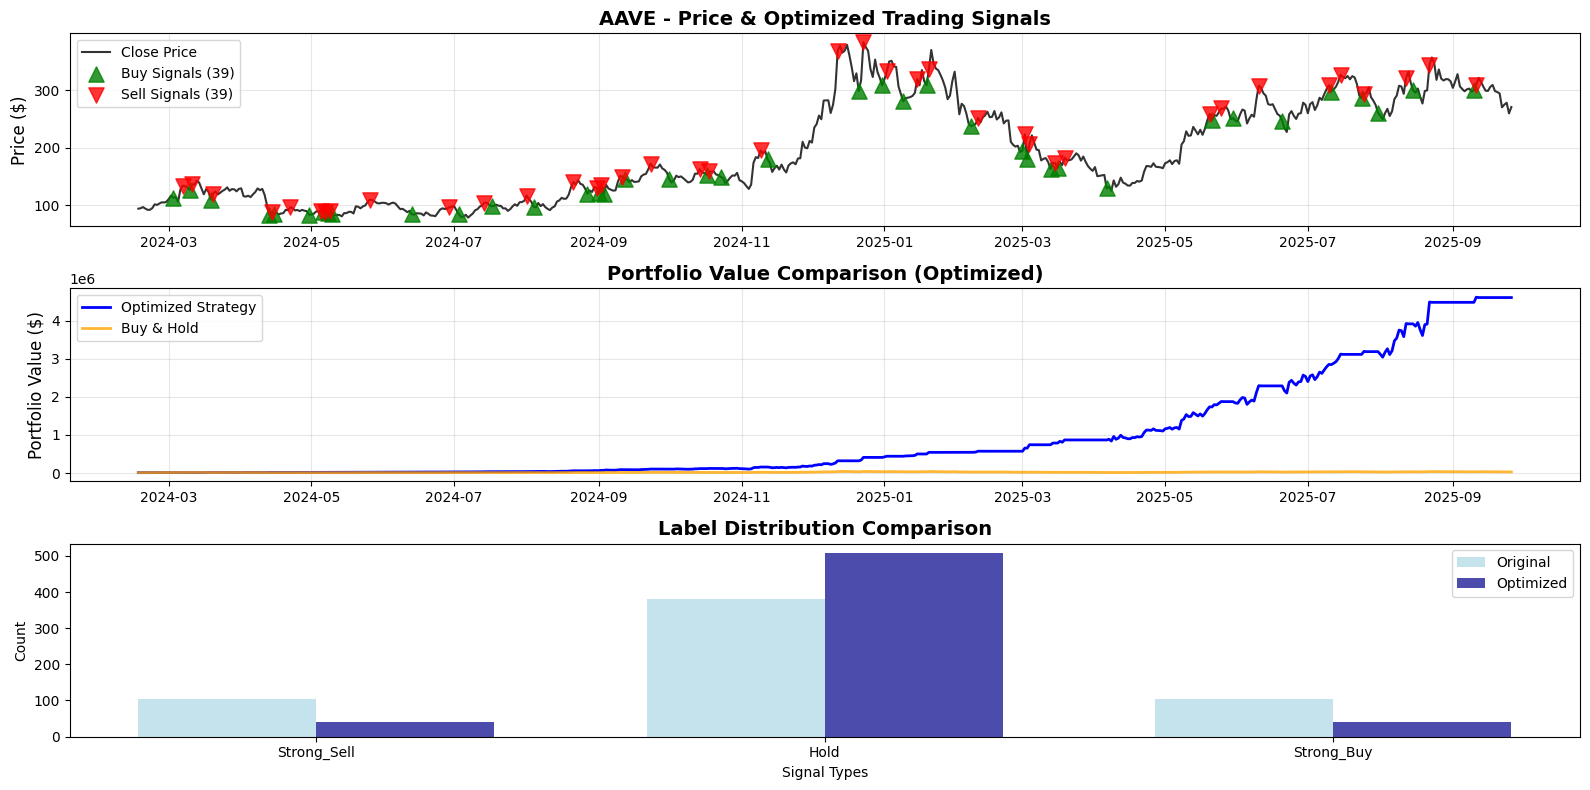

최적화된 백테스팅:  33%|███▎      | 1/3 [00:00<00:01,  1.96it/s]


🚀 ADA 최적화된 백테스팅 결과
📈 전략 수익률: 26837.63%
📊 Buy & Hold: 30.22%
⚡ 초과수익률: 26807.41%
📐 샤프 비율: 4.672
📉 최대손실폭: -11.85%
🔄 거래 횟수: 76회
🎯 승률: 100.00%
💰 평균 거래수익률: 18.97%
💵 최종 자산: $2,693,763
📅 기간: 2024-02-17 ~ 2025-09-26
📊 데이터 포인트: 588일


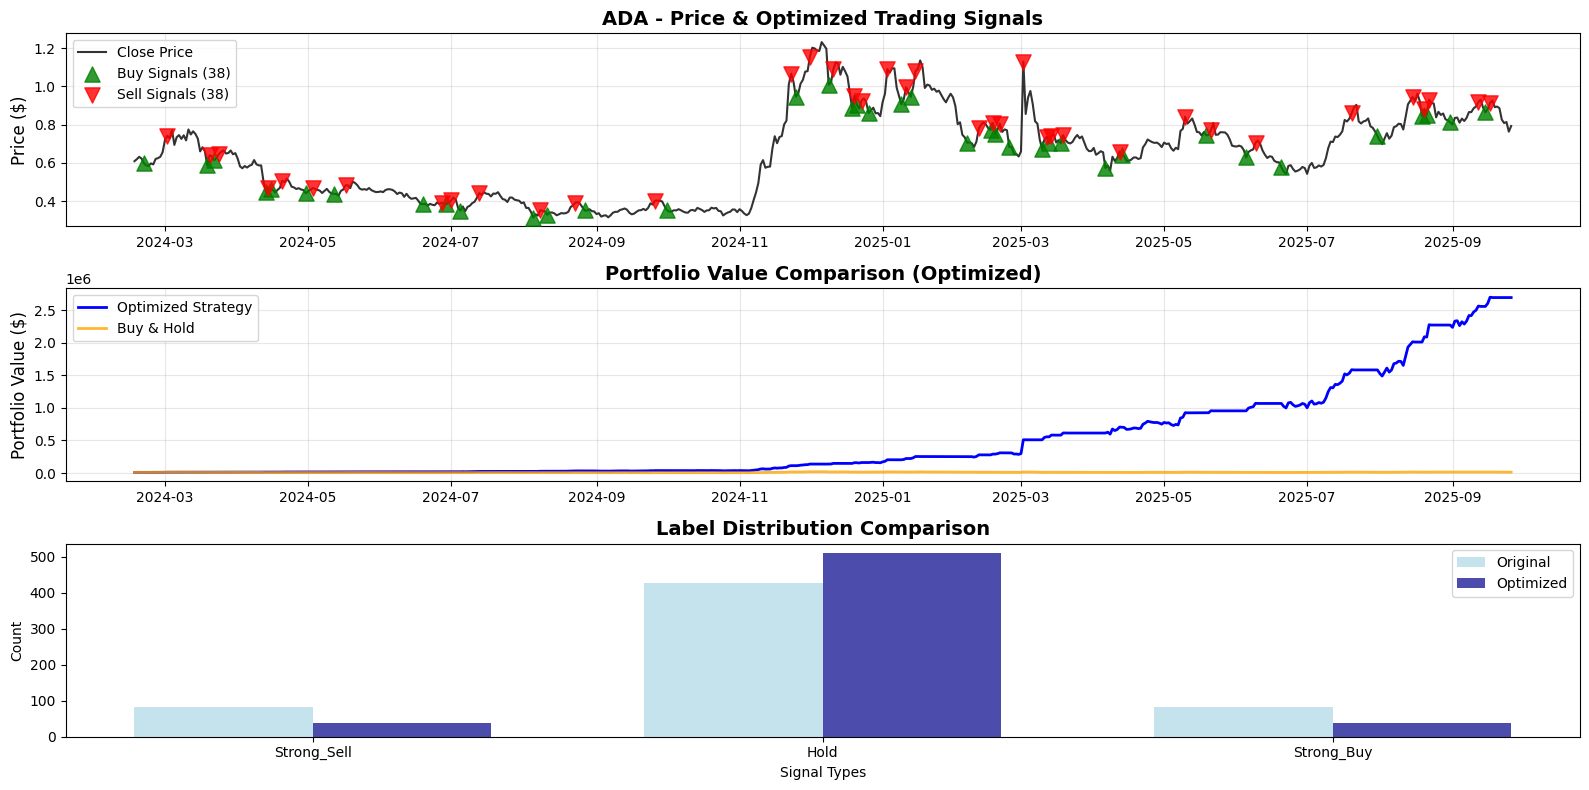

최적화된 백테스팅:  67%|██████▋   | 2/3 [00:01<00:00,  1.99it/s]


🚀 AETHWETH 최적화된 백테스팅 결과
📈 전략 수익률: 262.66%
📊 Buy & Hold: 61.73%
⚡ 초과수익률: 200.93%
📐 샤프 비율: 7.012
📉 최대손실폭: -7.99%
🔄 거래 횟수: 24회
🎯 승률: 91.67%
💰 평균 거래수익률: 12.67%
💵 최종 자산: $36,266
📅 기간: 2025-05-12 ~ 2025-09-26
📊 데이터 포인트: 138일


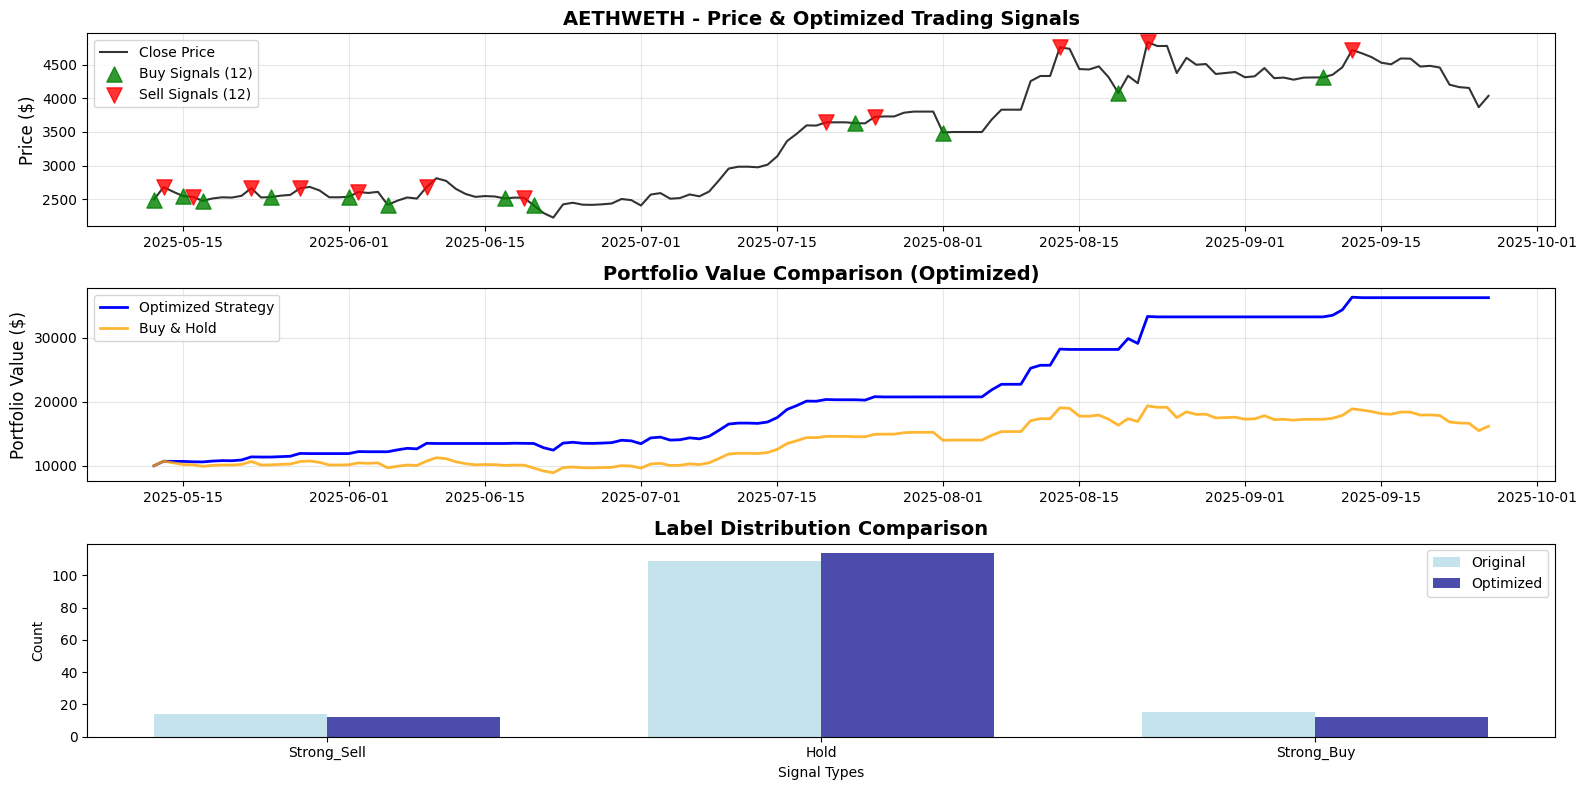

최적화된 백테스팅: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


✅ 백테스팅 완료: 3/3개 성공

🎯 최적화된 전체 백테스팅 결과 요약
  Symbol  Total_Return  Buy_Hold_Return  Excess_Return  Sharpe_Ratio  Max_Drawdown  Win_Rate  Num_Trades  Data_Points
    AAVE      459.1874           1.8890       457.2985        5.3921       -0.1796    1.0000          78          588
     ADA      268.3763           0.3022       268.0741        4.6719       -0.1185    1.0000          76          588
AETHWETH        2.6266           0.6173         2.0093        7.0118       -0.0799    0.9167          24          138

📊 평균 통계:
   평균 수익률: 24339.68%
   평균 초과수익률: 24246.06%
   평균 샤프비율: 5.692
   평균 승률: 97.22%

🎉 모든 백테스팅 완료!
💾 결과는 backtester.results에 저장되었습니다.


In [10]:
# 실행 코드
if __name__ == "__main__":
    save_path_1 = "/workspace/AI모델/projects/coin/data/v01/optimized"
    
    # 개별 종목 백테스팅 실행
    backtester, summary_df = run_individual_backtest(
        data_path=save_path_1,
        start_date='2024-02-17',    # 백테스팅 시작 날짜
        end_date='2025-09-27',      # 백테스팅 종료 날짜
        max_stocks=3,              # 최대 10개 종목 테스트
        initial_capital=10000       # 초기 투자 금액
    )
    
    if backtester and summary_df is not None:
        print(f"\n🎉 모든 백테스팅 완료!")
        print(f"💾 결과는 backtester.results에 저장되었습니다.")
    else:
        print("❌ 백테스팅 실패")